### Histopathologic Cancer Detection

### Introduction

This project aims to develop a deep learning binary classification model to identify cancer in small pathology images. Using convolutional neural network architecture (CNN), this project sought to understand the relationships within the data and classify instances accurately.

The dataset was taken from a Kaggle competition and includes small pathology images. The train set was labeled to differentiate between cancerous and non-cancerous images, while the test set was unlabeled.

### Modeling Approach

Models are trained below. This project started with a simple model called Model 1, and increased in complexity with Model 2 and Model 3 seeking to improve performance. The number of epochs used for training was determined by early stopping to avoid overfitting. Helper functions were created to expedite the evaluation process.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_dir = os.getcwd()

In [4]:
train_labels = 'train_labels.csv'
df = pd.read_csv(train_labels)

In [5]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


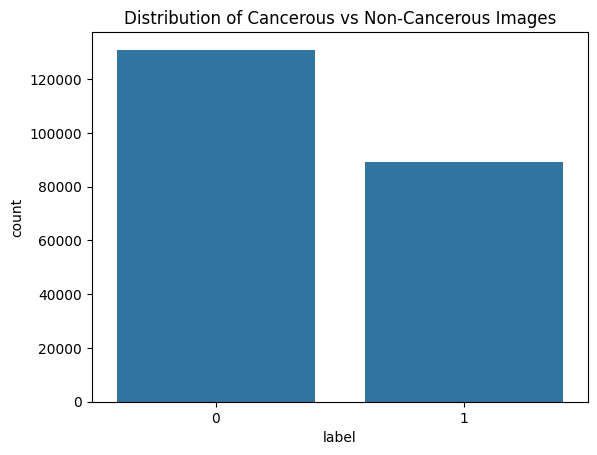

In [6]:
sns.countplot(data = df, x = 'label')
plt.title('Distribution of Cancerous vs Non-Cancerous Images')
plt.show()

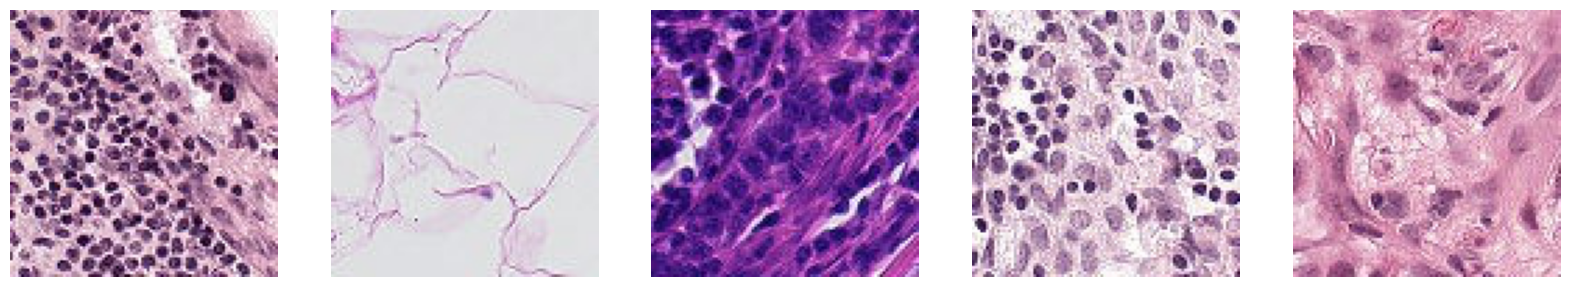

In [7]:
def show_random_images(df, n=5):
    fig, axes = plt.subplots(1, n, figsize=(20, 5))
    for i, ax in enumerate(axes):
        img_name = df['id'].sample(1).values[0]
        img_path = os.path.join(r'train', f'{img_name}.tif')
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

show_random_images(df)

In [8]:
print(f"Total images: {df.shape[0]}")
print(f"Number of cancerous images: {df[df['label'] == 1].shape[0]}")
print(f"Number of non-cancerous images: {df[df['label'] == 0].shape[0]}")

Total images: 220025
Number of cancerous images: 89117
Number of non-cancerous images: 130908


In [9]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def custom_data_generator(dataframe, directory, target_size=(96, 96), batch_size=32, file_extension=".tif"):
    while True:
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle data

        for i in range(0, len(dataframe), batch_size):
            batch_df = dataframe[i:i + batch_size]
            images = []
            labels = []
            for index, row in batch_df.iterrows():
                img_path = os.path.join(directory, row['id'] + file_extension)
                image = load_img(img_path, target_size=target_size) 
                image = img_to_array(image) / 255.0 
                images.append(image)
                labels.append(row['label']) 

            yield np.array(images), np.array(labels)


In [10]:
def test_data_generator(dataframe, directory, target_size=(96, 96), batch_size=32, file_extension=".tif"):
    while True:
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)

        for i in range(0, len(dataframe), batch_size):
            batch_df = dataframe[i:i + batch_size]
            images = []
            for index, row in batch_df.iterrows():
                img_path = os.path.join(directory, row['id'] + file_extension)
                image = load_img(img_path, target_size=target_size)
                image = img_to_array(image) / 255.0  # Normalize
                images.append(image)

            yield np.array(images)

In [11]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

print(f"Train samples: {len(df_train)}, Validation samples: {len(df_val)}")

Train samples: 176020, Validation samples: 44005


In [12]:
train_dir = data_dir + '/train'

In [13]:
# create train and validation generators
train_generator = custom_data_generator(df_train, train_dir, target_size=(96, 96), batch_size=32, file_extension=".tif")
val_generator = custom_data_generator(df_val, train_dir, target_size=(96, 96), batch_size=32, file_extension=".tif")

### Model 1

#### Building and Training Model 1

In [14]:
strategy = tf.distribute.get_strategy()
print('Number of devices:', strategy.num_replicas_in_sync)

Number of devices: 1


In [15]:
with strategy.scope():
    model1 = Sequential()
    model1.add(Conv2D(16,
                      (3, 3),
                      activation='relu',
                      input_shape=(96, 96, 3)))
    model1.add(MaxPooling2D(2, 2))
    model1.add(Flatten())
    model1.add(Dense(32, activation='relu'))
    model1.add(Dense(1, activation='sigmoid'))


    model1.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
    print(model1.summary())

    checkpoint = ModelCheckpoint(filepath='model1.h5',
                                 monitor='val_loss',
                                 save_best_only = True,
                                 mode = 'min',
                                 verbose = 1)

    early_stopping = EarlyStopping(monitor = 'val_loss',
                                   patience = 3,
                                   restore_best_weights = True)

    history_model1 = model1.fit(train_generator,
                                epochs = 10,
                                steps_per_epoch = len(df_train) // 32,
                                validation_data = val_generator,
                                callbacks = [checkpoint, early_stopping],
                                validation_steps = len(df_val) // 32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 35344)             0         
                                                                 
 dense (Dense)               (None, 32)                1131040   
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1131521 (4.32 MB)
Trainable params: 1131521 (4.32 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

2024-12-05 14:34:43.005690: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-12-05 14:34:43.005751: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-12-05 14:34:43.005762: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-12-05 14:34:43.005855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-05 14:34:43.006144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


None
Epoch 1/10


2024-12-05 14:34:43.395901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5499/5500 [============================>.] - ETA: 0s - loss: 0.5364 - accuracy: 0.7637
Epoch 1: val_loss improved from inf to 0.45878, saving model to model1.h5
5500/5500 [==============================] - 105s 19ms/step - loss: 0.5364 - accuracy: 0.7637 - val_loss: 0.4588 - val_accuracy: 0.7928
Epoch 2/10
5500/5500 [==============================] - ETA: 0s - loss: 0.4614 - accuracy: 0.7930
Epoch 2: val_loss improved from 0.45878 to 0.45133, saving model to model1.h5
5500/5500 [==============================] - 77s 14ms/step - loss: 0.4614 - accuracy: 0.7930 - val_loss: 0.4513 - val_accuracy: 0.8046
Epoch 3/10
5499/5500 [============================>.] - ETA: 0s - loss: 0.4884 - accuracy: 0.7863
Epoch 3: val_loss did not improve from 0.45133
5500/5500 [==============================] - 71s 13ms/step - loss: 0.4883 - accuracy: 0.7864 - val_loss: 0.4816 - val_accuracy: 0.8025
Epoch 4/10
5497/5500 [============================>.] - ETA: 0s - loss: 0.4693 - accuracy: 0.7898
Epoch 4: val_l

In [16]:
def plot_training_performance(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc), + 1)

    #accuracy plot
    plt.figure(figsize = (12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, 'o-', label = 'Training Accuracy')
    plt.plot(val_acc, 'o-', label = 'Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc = 'upper left')

    #loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, 'o-', label = 'Training Loss')
    plt.plot(val_loss, 'o-', label = 'Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc = 'upper right')
    
    plt.tight_layout()
    plt.show

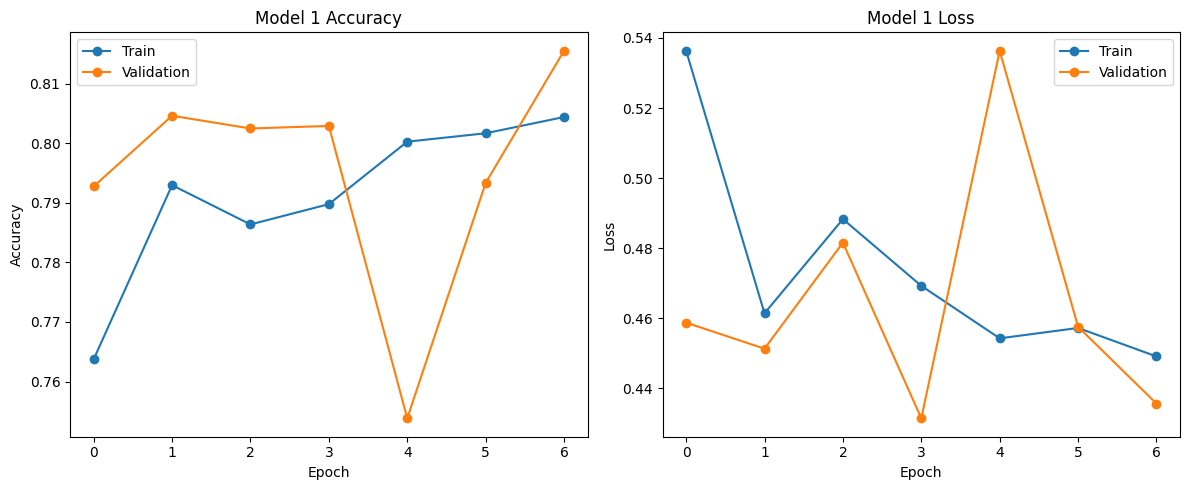

In [17]:
plot_training_performance(history_model1, "Model 1")

#### Testing Model 1

In [18]:
test_dir = os.path.join(data_dir, 'test')
test_filenames = os.listdir(test_dir)
test_filenames_clean = [os.path.splitext(f)[0] for f in test_filenames]

In [19]:
def load_test_images(filenames, directory, target_size=(96, 96)):
    images = []
    for filename in filenames:
        img_path = os.path.join(directory, filename)
        image = load_img(img_path, target_size=target_size)
        image = img_to_array(image) / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

In [20]:
test_images = load_test_images(test_filenames, test_dir)

In [21]:
def cnn_test(model, test_images):
    predicitons = model.predict(test_images)
    predicted_classes = (predicitons > 0.5).astype(int).flatten()

    return predicted_classes

In [22]:
def cnn_results_df(test_filenames_clean, predicted_classes):
    results_df = pd.DataFrame({
        'id': test_filenames_clean,
        'label': predicted_classes
    })
    
    return results_df

In [23]:
model1 = load_model("model1.h5")

In [24]:
model1_predicted_classes = cnn_test(model1, test_images)

1796/1796 [==============================] - 4s 2ms/step


In [25]:
model1_results_df = cnn_results_df(test_filenames_clean, model1_predicted_classes)

In [26]:
def save_model_results(results_df, model, results_fname = 'results.csv', model_fname = 'model.keras'):
    
    #save results df to csv
    results_df.to_csv(results_fname, index = False)
    print(f'Results saved to {results_fname}')

    #save model to .keras format
    model.save(model_fname)
    print(f'Model saved as {model_fname}')


In [27]:
save_model_results(model1_results_df, model1, 'model1_results.csv', 'model1.keras')

Results saved to model1_results.csv
Model saved as model1.keras


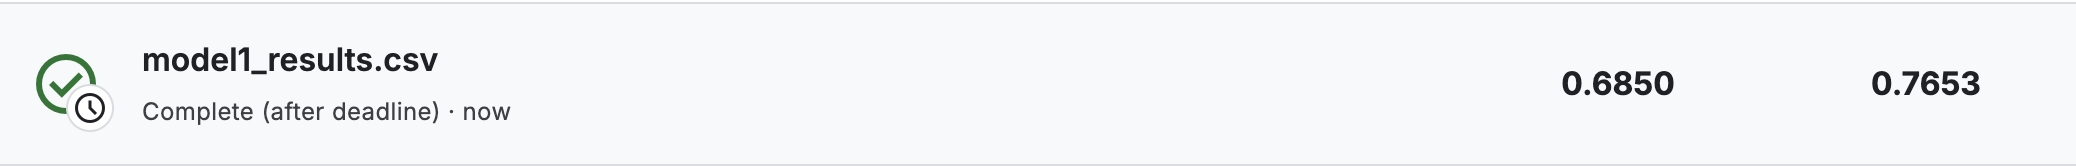

### Model 2

#### Building and Training Model 2

In [28]:
with strategy.scope():
    model2 = Sequential()
    model2.add(Conv2D(32,
                      (3, 3),
                      activation='relu',
                      input_shape=(96, 96, 3)))
    model2.add(MaxPooling2D(2, 2))
    model2.add(Conv2D(64,
                      (3, 3),
                      activation='relu'))
    model2.add(MaxPooling2D(2, 2))
    model2.add(Flatten())
    model2.add(Dense(128, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(1, activation='sigmoid'))

    model2.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
    print(model2.summary())

    checkpoint = ModelCheckpoint(filepath='model2.h5',
                                 monitor='val_loss',
                                 save_best_only = True,
                                 mode = 'min',
                                 verbose = 1)

    early_stopping = EarlyStopping(monitor = 'val_loss',
                                   patience = 3,
                                   restore_best_weights = True)

    history_model2 = model2.fit(train_generator,
                                epochs = 10,
                                steps_per_epoch = len(df_train) // 32,
                                validation_data = val_generator,
                                callbacks = [checkpoint, early_stopping],
                                validation_steps = len(df_val) // 32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 30976)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

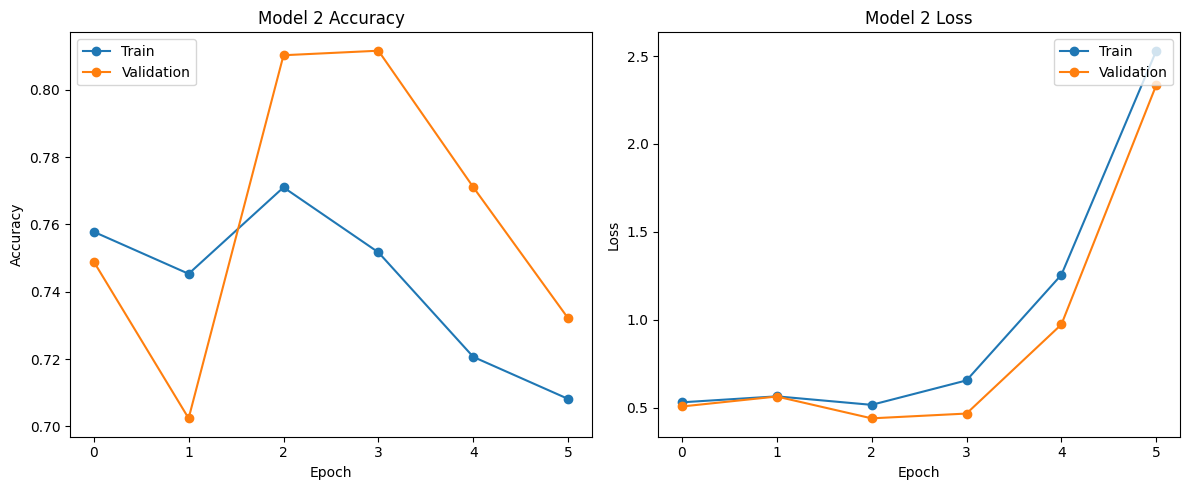

In [29]:
plot_training_performance(history_model2, "Model 2")

In [30]:
model2 = load_model("model2.h5")

In [31]:
model2_predicted_classes = cnn_test(model2, test_images)

1796/1796 [==============================] - 5s 3ms/step


In [32]:
model2_results_df = cnn_results_df(test_filenames_clean, model2_predicted_classes)

In [33]:
save_model_results(model2_results_df, model2, 'model2_results.csv', 'model2.keras')

Results saved to model2_results.csv
Model saved as model2.keras


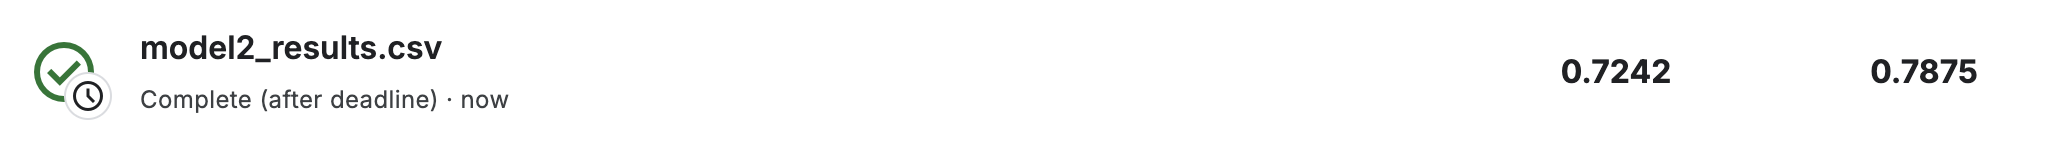

### Model 3

In [34]:
with strategy.scope():
    model3 = Sequential()
    model3.add(Conv2D(32,
                      (3, 3),
                      activation = 'relu',
                      input_shape = (96, 96, 3)))
    model3.add(MaxPooling2D(2, 2))
    model3.add(Conv2D(64,
                      (3, 3),
                      activation = 'relu'))
    model3.add(MaxPooling2D(2, 2))
    model3.add(Conv2D(128,
                      (3, 3),
                      activation = 'relu',
                      kernel_regularizer = l2(0.01)))
    model3.add(MaxPooling2D(2, 2))
    model3.add(Dropout(0.2))
    model3.add(Flatten())
    model3.add(Dense(128,
                     activation = 'relu'))
    model3.add(Dropout(0.5))
    model3.add(Dense(1, activation = 'sigmoid'))

    model3.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
    print(model3.summary())

    checkpoint = ModelCheckpoint(filepath = 'model3.h5',
                                 monitor = 'val_loss',
                                 save_best_only = True,
                                 mode = 'min',
                                 verbose = 1)

    early_stopping = EarlyStopping(monitor = 'val_loss',
                                   patience = 3,
                                   restore_best_weights = True)

    history_model3 = model3.fit(train_generator,
                                epochs = 10,
                                steps_per_epoch = len(df_train) // 32,
                                validation_data = val_generator,
                                callbacks = [checkpoint, early_stopping],
                                validation_steps = len(df_val) // 32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 128)      

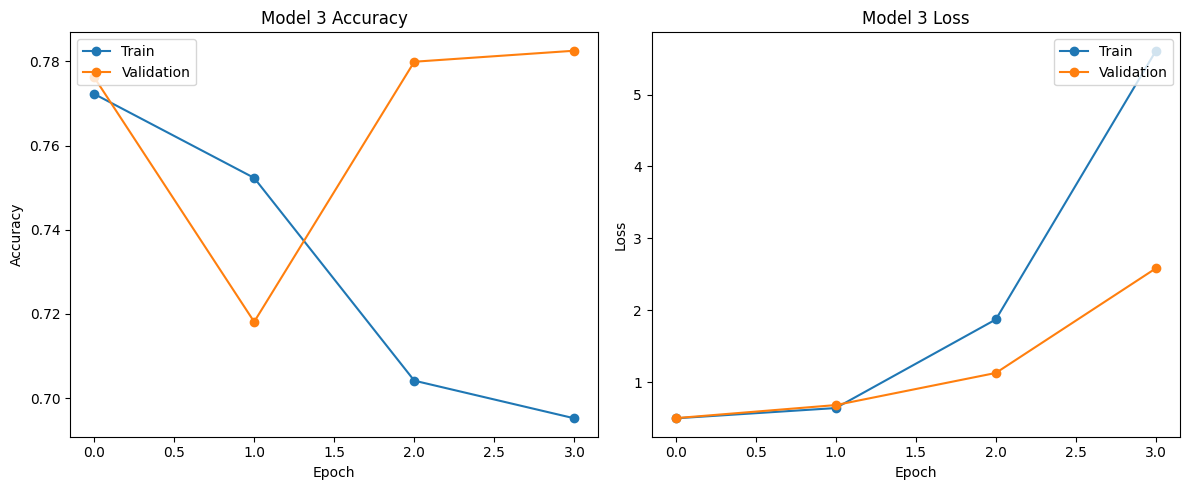

In [35]:
plot_training_performance(history_model3, "Model 3")

In [36]:
model3 = load_model("model3.h5")

In [37]:
model3_predicted_classes = cnn_test(model3, test_images)

1796/1796 [==============================] - 5s 3ms/step


In [38]:
model3_results_df = cnn_results_df(test_filenames_clean, model3_predicted_classes)

In [39]:
save_model_results(model3_results_df, model3, 'model3_results.csv', 'model3.keras')

Results saved to model3_results.csv
Model saved as model3.keras


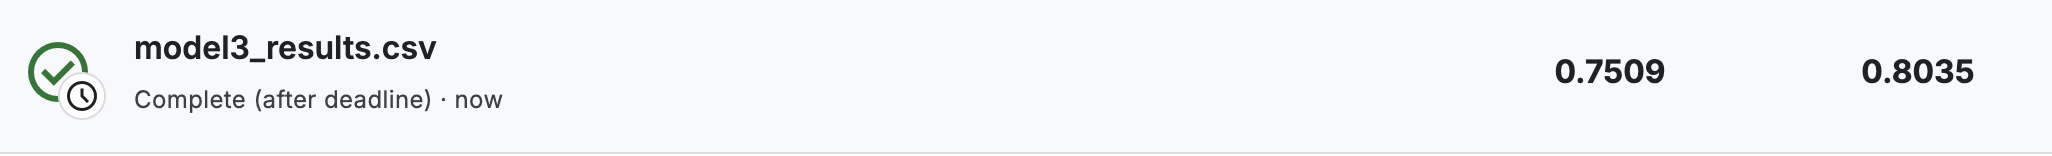

### Results

The Kaggle competition itself evaluates submissions on the area under the ROC curve between the predicted probability and observed target. With that being said, Model 3 perfomred the best with the highest private and public scores. Model 1 had the lowest scores, while Model 2 had the middle scores.

### Discussion

All scores still suggests that each of the models are not yet optimal due to not quite capturing the complexity of the data and overfitting the training data. Improvements to this project would include further experimentation with different dropout rates, regularization, or larger convolutional layers to improve performance.